In [105]:
import numpy as np, matplotlib.pyplot as plt

In [113]:
G = 6.6743e-11
M0 = 1.989e30
AU = 1.496e11

M1 = 1.12 # * M0
M2 = 1.37 # * M0
q = M2 / M1 # TODO: check if this should be the other way round
a = 0.54 # * AU
OMEGA = np.sqrt(G * (M1 + M2) / (a**3)) # * np.sqrt(M0 / (AU**3))
m = 1 # ?? TODO: figure out what this should be

In [107]:
def plot_2d_profile(
    values: np.ndarray[np.float64], *,
    colourmap: str = "viridis",
    title: str = "Profile",
    x_label: str = "x", y_label: str = "y",
    colour_bar_name: str = "Value",
    figure_size: tuple[int, int] = (6, 6),
    vmin: float = None, vmax: float = None,
    colour_contrast_style: str = "90",
        # "symmetric" to set symmetric color limits around 0 (for signed fields)
        # "nonneg" to force vmin=0 and vmax=max (for non-negative fields)
    extent: list[float] | None = None,
    alpha: float = 1
) -> None:
    """
    Plots a 2D numpy array of values on a grid with a colour bar.
    """
    # Auto colour scaling helpers
    if colour_contrast_style == "symmetric":    # colour bar ranges from - max val to + max val 
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto
        vmax_plot =  vmax_auto
    elif colour_contrast_style == "nonneg":     # colour bar ranges from 0 to max val
        vmin_plot = 0.0
        vmax_plot = np.nanmax(values)
    elif colour_contrast_style == "90":         # colour bar ranges from 10th percentile to 90th percentile
        vmin_plot = np.percentile(values, 5)
        vmax_plot = np.percentile(values, 95)
    elif (
        colour_contrast_style == "custom" and   # colour bar ranges from vmin to vmax
        vmin is not None and vmax is not None
    ):
        vmin_plot = vmin
        vmax_plot = vmax
    else:
        raise Exception("invalid colour contrast arguments")

    plt.figure(figsize = figure_size)

    img = plt.imshow(
        values,
        origin="lower",
        cmap=colourmap,
        aspect="equal",
        vmin=vmin_plot, vmax=vmax_plot,
        extent=extent,
        alpha=alpha
    )

    cbar = plt.colorbar(img)
    cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [108]:
def plot_polar_profile(
    r_grid: np.ndarray[np.float64],
    theta_grid: np.ndarray[np.float64],
    values: np.ndarray[np.float64],
    num_contours: int = 50,
    colourmap: str = "inferno",
    title: str = "Brightness Profile",
    colour_bar_name: str = "Value",
    figure_size: tuple[int, int] = (6, 6),
    vmin: float = None, vmax: float = None,
    colour_contrast_style: str = "90",
        # "symmetric" to set symmetric color limits around 0 (for signed fields)
        # "nonneg" to force vmin=0 and vmax=max (for non-negative fields)
    save_info: bool = False,
    fname: str | None = None
) -> None:
    """
    Plots a 2D numpy array of polar values (r, theta) on a disk with a colour bar.
    """
    # Auto colour scaling helpers
    if colour_contrast_style == "symmetric":    # colour bar ranges from - max val to + max val 
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto
        vmax_plot =  vmax_auto
    elif colour_contrast_style == "nonneg":     # colour bar ranges from 0 to max val
        vmin_plot = 0.0
        vmax_plot = np.nanmax(values)
    elif colour_contrast_style == "90":         # colour bar ranges from 10th percentile to 90th percentile
        vmin_plot = np.percentile(values, 5)
        vmax_plot = np.percentile(values, 95)
    elif (
        colour_contrast_style == "custom" and   # colour bar ranges from vmin to vmax
        vmin is not None and vmax is not None
    ):
        vmin_plot = vmin
        vmax_plot = vmax
    else:
        raise Exception("invalid colour contrast arguments")


    fig, ax = plt.subplots(figsize=figure_size, subplot_kw=dict(projection="polar"))
    contour = ax.contourf(
        theta_grid, r_grid, values,
        levels=num_contours,
        vmin=vmin_plot, #TODO: fix this
        vmax=vmax_plot,
        cmap=colourmap
    )
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label(colour_bar_name)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if save_info:
        if fname is None:
            raise Exception("invalid intens_func_name")
        plt.savefig(fname)
    plt.show()



In [109]:
def get_roche(
    x_grid: np.ndarray[np.float64],
    y_grid: np.ndarray[np.float64],
    x1: float, y1: float,
    x2: float, y2: float
) -> np.ndarray[np.float64]:
    term1 = M1 * (
        (x_grid - x1) ** 2 + (y_grid - y1) ** 2
    ) ** (-0.5)
    term2 = M2 * (
        (x_grid - x2) ** 2 + (y_grid - y2) ** 2
    ) ** (-0.5)
    term3 = (M1 + M2) * (x_grid ** 2 + y_grid ** 2) / (2 * a**3)
    return -G * (term1 + term2 + term3) * M0 / AU # TODO: check M0/AU multiplying factor

In [110]:
def get_acc(
    x: float, y: float,
    x1: float, y1: float,
    x2: float, y2: float
) -> np.ndarray[np.float64]:
    term1 = np.array([x - x1, y - y1])
    term1 *= M1 * (
        (x - x1) ** 2 + (y - y1) ** 2
    ) ** (-1.5)
    term2 = np.array([x - x2, y - y2])
    term2 *= M2 * (
        (x - x2) ** 2 + (y - y2) ** 2
    ) ** (-1.5)
    term3 = - (M1 + M2) / (2 * a**3) * np.array([x, y])
    return G / m * (term1 + term2 + term3) * M0 / (AU ** 2) # TODO: check M0/AU multiplying factor

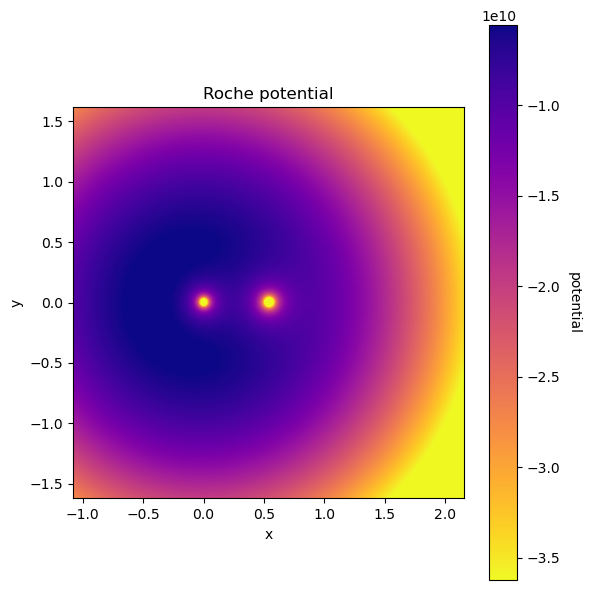

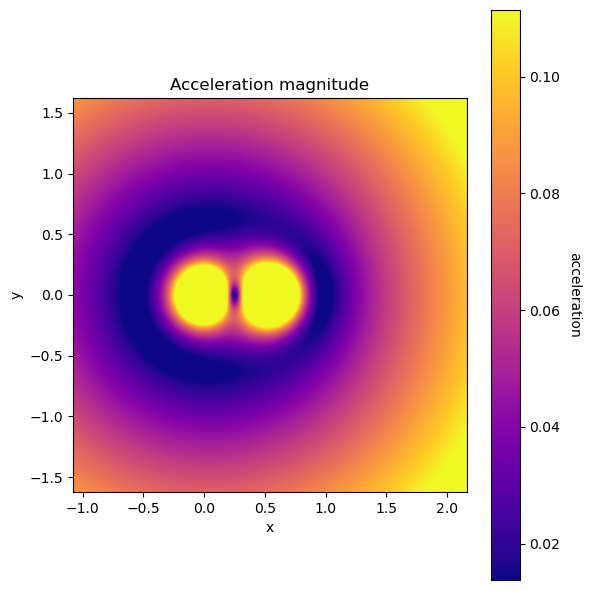

In [111]:
x1, y1 = (0, 0)
x2, y2 = (a, 0)

L1 = x1 + a * (0.5 + 0.227 * np.log(q))

plt_width = 3*a
plt_res = 400
x_coords = np.linspace(-plt_width + a, plt_width + a, plt_res)
y_coords = np.linspace(-plt_width, plt_width, plt_res)


x_grid, y_grid = np.meshgrid(x_coords, y_coords)
extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]

roche_pot = get_roche(x_grid, y_grid, x1, y1, x2, y2)
accel = get_acc(x_grid, y_grid, x1, y1, x2, y2)
accel_mag = np.hypot(accel[0], accel[1])

plot_2d_profile(
    roche_pot, extent=extent, alpha=1,
    colourmap="plasma_r", title="Roche potential",
    colour_bar_name="potential"
)
plot_2d_profile(
    accel_mag, extent=extent, alpha=1,
    colourmap="plasma", title="Acceleration magnitude",
    colour_bar_name="acceleration"
)

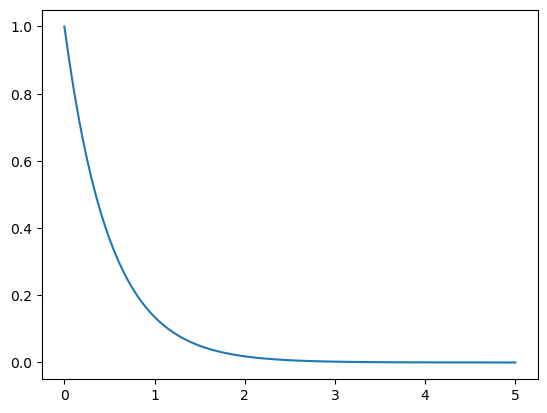

In [112]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# 1. Define the derivative function
def derivative_function(t, y):
    return -2 * y

# 2. Specify initial conditions
y0 = [1]  # Initial value of y at t=0

# 3. Define the time span
t_span = (0, 5)  # Integrate from t=0 to t=5

# Optional: Define specific time points to evaluate the solution
t_eval = np.linspace(0, 5, 100)

# 4. Call solve_ivp
solution = solve_ivp(derivative_function, t_span, y0, t_eval=t_eval)

# The solution is stored in the 'solution' object
# 'solution.t' contains the time points
# 'solution.y' contains the corresponding function values
# print("Time points:", solution.t)
# print("Function values:", solution.y[0])

plt.plot(solution.t, solution.y[0])
plt.show()